In [29]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from utility_db_25 import get_momentum_cols, create_momentum_index, get_final_features, get_motion_cols, motion_complexity_score, calc_tempo

expectedPointsAdded,

incorp penalty?

num times motion on drive

play of drive:

what looks they've been seeing on drive (man, zone, coverages?)
    -makes pff stats fair game
    -can incorp across all game

also calc personnel delta? hurry-up flag? TIMe REMAININg

but like, see how we can measure personnel changes play-over-play (weight helps?)

In [2]:
root_dir = os.getcwd()

In [5]:
train_data = pd.read_csv(os.path.join(root_dir,'data/train_data.csv'))
test_data = pd.read_csv(os.path.join(root_dir,'data/test_data.csv'))

In [6]:
include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data=train_data[include_columns]
test_data = test_data[include_columns]

In [7]:

motion_cols=get_motion_cols(train_data.columns)
momentum_cols=get_momentum_cols(train_data.columns)
train_data=create_momentum_index(train_data, momentum_cols)
test_data=create_momentum_index(test_data, momentum_cols)

train_data=motion_complexity_score(train_data, motion_cols)
test_data=motion_complexity_score(test_data, motion_cols)

In [8]:

df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
df_plays = df_plays.sort_values(by=['gameId','playId']).reset_index()

In [ ]:
# sub indices
df_plays = df_plays.sort_values(by=['gameId','playId']).reset_index()
df_plays = df_plays.merge(train_data[['gameId','playId']],how='inner')

In [12]:
len(df_plays)

14556

In [13]:
train_data.head(5)

,gameId,playId,quarter,down,yardsToGo,score_differential,time_remaining,playNullifiedByPenalty,preSnapHomeTeamWinProbability,pass_rush_ratio,...,QBdffy_RB,QBdffx_RB,QB_RB1_offset,QBdffy_G,QBdffy_T,QBdffy_WR,presnap_motion_complexity,motion-momentum,neg_Formations,neg_alignment
0,2022090800,56,1,1,10,0,60.000000,N,0.413347,2.72,...,12.998056,14.824618,5.123633,16.233102,13.369323,15.426681,1.0,1.0,0,0
1,2022090800,80,1,2,4,0,59.483333,N,0.413316,2.72,...,15.340632,18.708621,47.867692,16.355479,13.566580,17.363747,0.0,0.0,0,0
2,2022090800,101,1,1,10,0,58.900000,N,0.399819,2.72,...,11.885369,25.815721,5.446447,16.322415,13.353085,17.414404,1.0,1.0,1,1
3,2022090800,122,1,2,3,0,58.250000,N,0.384969,2.72,...,12.955991,24.846486,4.510910,16.359189,13.456644,15.283333,0.0,0.0,0,1
4,2022090800,167,1,2,8,0,56.900000,N,0.387554,2.72,...,22.205317,29.666350,232.110880,19.975856,16.031817,17.259033,0.0,0.0,0,0


In [14]:
[x for x in train_data if 'pass' in x]

['pass_rush_ratio',
 'pass',
 'pass_rate_off',
 'off_xpass',
 'def_xpass',
 'pass_val',
 'xpass_situational',
 'pass_rate_def']

In [15]:
len(df_plays)

14556

### Track current drive pass rate stats

We want to track pass rate for the current drive, to dovetail with our "Tempo" idea

In [16]:
last_team = df_plays['possessionTeam'][0] # monitor what the last team updated was, implies switch if different
pnum=0 # play number of drive
pc = 0 # pass count
pnum_ls = [] # play number list
flag_ls = [] # switch flag list
curr_pr_ls = [] # pass rate for current drive
pr_ls = [] # overall pass_rate ls
curr_clock_ls = [] # play clock for run
clock_ls = [] # play clock tracker
curr_epa_ls = [] #list of current drive epa
epa_ls = [] #overall epa list

# loop over plays
for index, row in df_plays.iterrows():

    curr_team = row['possessionTeam']
    flag = 0

    # if we've switched teams, reset drive tracking info/add last drive's info to running list
    if last_team != curr_team:

        # reset pass count, play number for drive

        last_team = curr_team # reset team to know we're on current drive now
        pc = 0 # reset pass count, etc.
        pnum = 0
        flag = 1

        # append current clock, epa, pass rate stats to running lists
        clock_ls.append([10] + list(np.cumsum(curr_clock_ls)/np.arange(1,len(curr_clock_ls)+1))[:-1]) # assume 10 seconds left on play clock, can adjust later
        pr_ls.append([.6] + curr_pr_ls[:-1]) # lookback of one, use .6 for first play of drive (default pass rate)
        epa_ls.append([.0] + list(np.cumsum(curr_epa_ls)/np.arange(1,len(curr_epa_ls)+1))[:-1]) # inelegantly impute an EPA of zero for our first timestep
        
        # reset current drive stat lists
        curr_pr_ls = []
        curr_clock_ls = []
        curr_epa_ls = []
        

    # if not switching teams, update current drive's pass rate
    if row['isDropback']:
        pc+=1
    pnum += 1
    pr = pc/pnum

    # get current mean clock used per drive
    clock = row['playClockAtSnap']
    epa = row['expectedPointsAdded']
    
    # update pass rate, play number, possession, etc. for current drive
    pnum_ls.append(pnum)
    flag_ls.append(flag)
    curr_pr_ls.append(pr)
    curr_clock_ls.append(clock)
    curr_epa_ls.append(epa)

# if new drive not logged, append
if len(list(chain(*pr_ls))) < len(df_plays):
    pr_ls.append([.6] + curr_pr_ls[:-1])
if len(list(chain(*clock_ls))) < len(df_plays):
    clock_ls.append([10] + curr_clock_ls[:-1])
if len(list(chain(*epa_ls))) < len(df_plays):
    epa_ls.append([0] + curr_epa_ls[:-1])

We then flatten our aggregated lists, to use as features

In [17]:
# flatten running lists using using iter chain
pr_flat = list(chain(*pr_ls))
clock_flat = list(chain(*clock_ls))
epa_flat = list(chain(*epa_ls))

# estalish new features
df_plays['drive_play_num'] = pnum_ls
df_plays['pos_switch_flag'] = flag_ls
df_plays['drive_pass_rate'] = pr_flat
df_plays['mean_clocksnap'] = clock_flat
df_plays['mean_epa'] = epa_flat

Then examine an example drive

In [18]:
df_plays[['possessionTeam','drive_play_num','pos_switch_flag','drive_pass_rate','mean_clocksnap','mean_epa','isDropback']].head(11)

,possessionTeam,drive_play_num,pos_switch_flag,drive_pass_rate,mean_clocksnap,mean_epa,isDropback
0,BUF,1,0,0.600000,10.000000,0.000000,True
1,BUF,2,0,1.000000,12.000000,0.004420,True
2,BUF,3,0,1.000000,14.000000,0.413995,False
3,BUF,4,0,0.666667,13.666667,0.463451,True
4,BUF,5,0,0.750000,12.500000,0.447391,True
5,BUF,6,0,0.800000,11.800000,0.632601,False
6,BUF,7,0,0.666667,12.000000,0.458280,True
7,BUF,8,0,0.714286,11.714286,0.471004,True
8,LA,1,1,0.600000,10.000000,0.000000,False
9,LA,2,0,0.000000,18.000000,-0.105841,False


### Explore relation between drive-based columns and pass likelihood

Drive pass rate/mean snap time among most informative df_play features;

Want no overlap w/down-distance features, which seems to be the case.

While 'mean_epa' implies a strong negative correlation with pass rate, it's very correlated w/'down', and ergo redundant

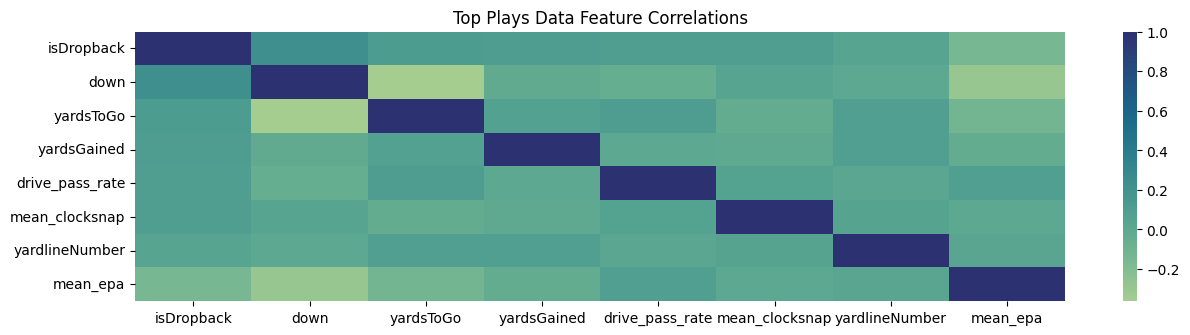

In [19]:
top_cols = df_plays.corr()['isDropback'].sort_values(ascending=False).head(9).index
plt.figure(figsize=(15,3.5))
sns.heatmap(df_plays[[x for x in top_cols if 'prePenaltyYardsGained' not in x and 'playAction' not in x]+['mean_epa']].corr(), cmap="crest")


plt.title('Top Plays Data Feature Correlations');
plt.xticks(rotation=0);

In [20]:
df_plays[[x for x in top_cols if 'prePenaltyYardsGained' not in x and 'playAction' not in x]+['mean_epa']].corr()

,isDropback,down,yardsToGo,yardsGained,drive_pass_rate,mean_clocksnap,yardlineNumber,mean_epa
isDropback,1.000000,0.224330,0.111457,0.102762,0.093276,0.092062,0.044280,-0.142250
down,0.224330,1.000000,-0.362524,-0.017735,-0.049685,0.042468,0.004187,-0.294138
yardsToGo,0.111457,-0.362524,1.000000,0.071383,0.104843,-0.033049,0.081324,-0.119917
yardsGained,0.102762,-0.017735,0.071383,1.000000,0.006260,-0.002578,0.080465,-0.032579
drive_pass_rate,0.093276,-0.049685,0.104843,0.006260,1.000000,0.061127,0.022814,0.080999
mean_clocksnap,0.092062,0.042468,-0.033049,-0.002578,0.061127,1.000000,0.050940,0.007547
yardlineNumber,0.044280,0.004187,0.081324,0.080465,0.022814,0.050940,1.000000,0.026624
mean_epa,-0.142250,-0.294138,-0.119917,-0.032579,0.080999,0.007547,0.026624,1.000000


In [21]:
df_plays['tempo'] = .1*df_plays['mean_clocksnap'] + df_plays['drive_pass_rate'] - df_plays['mean_epa']
df_plays['tempo'] = df_plays['tempo']/df_plays['tempo'].max()

In [22]:
import pandas as pd
from sklearn import preprocessing

In [27]:
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))

In [30]:
calc_tempo(df_plays)

In [31]:
df_plays[['mean_clocksnap','drive_pass_rate','tempo','isDropback']].head(3)

,mean_clocksnap,drive_pass_rate,tempo,isDropback
0,10.0,0.6,0.165378,True
1,10.0,1.0,0.134089,True
2,10.0,0.6,0.165378,True


In [32]:
df_plays[['mean_clocksnap','drive_pass_rate','tempo','isDropback']].corr()['isDropback']

mean_clocksnap    -0.012063
drive_pass_rate    0.003882
tempo              0.004696
isDropback         1.000000
Name: isDropback, dtype: float64

In [33]:
train_data.merge(df_plays[['gameId','playId','mean_clocksnap','drive_pass_rate','tempo']],how='left',on=['gameId','playId'])[['mean_clocksnap','drive_pass_rate','tempo','pass']].corr()

,mean_clocksnap,drive_pass_rate,tempo,pass
mean_clocksnap,1.000000,-0.053925,0.348386,-0.013061
drive_pass_rate,-0.053925,1.000000,0.259836,0.002918
tempo,0.348386,0.259836,1.000000,0.003811
pass,-0.013061,0.002918,0.003811,1.000000


In [34]:
train_data.merge(df_plays[['gameId','playId','mean_clocksnap','drive_pass_rate','tempo']],how='left',on=['gameId','playId'])[['mean_clocksnap','drive_pass_rate','tempo','pass']].isna().sum()

mean_clocksnap     0
drive_pass_rate    0
tempo              0
pass               0
dtype: int64